# Convolution Neural Network Classifier for CIFAR-10

I used a [Convolution Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) to the classify the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset with 75% accuracy.

CNNs have been applied to image classification and have achived near [human level accuracy](http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/).  The highest accuracy networks are trained against large image sets such as [ImageNet](http://image-net.org/) and require a lot computing power to train.  CIFAR-10 is a much smaller dataset and will require less computing power and yet is of reasonable complexity to be non-trival.  

The approach and much of the supporting code comes from Stanford University's [cs231n](http://cs231n.stanford.edu/) class.  All of the course materials are available on line and the lectures are avaiable on [youtube](https://www.youtube.com/watch?v=g-PvXUjD6qg&list=PLlJy-eBtNFt6EuMxFYRiNRS07MCWN5UIA).

The coding for this class is all numpy.  I've writen the code for all of the different types of neural network [layers](https://github.com/martykube/cs231n/blob/master/assignment2/cs231n/layers.py) and for [stochastic gradient descent](https://github.com/martykube/cs231n/blob/master/assignment1/cs231n/classifiers/neural_net.py).  This includes forward pass and backpropagation of gradients on the computational graphs.  Much of the supporting code such as gradient testing and image loading was provided in the course materials.  Likewise, many of the code snippets in this notebook come from the class materials.

Let's start by looking at the CIFAR-10 dataset.

In [1]:
# some  setup
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10, get_CIFAR10_data
%matplotlib inline

From the CIFAR-10 website:
>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

We've segregated the dataset into 3 groups:
1. 49,000 images for training
2. 1,000 images for validation when selecting hyper-parameters
3. 1,000 images in the test set.

Let's look at a few images.

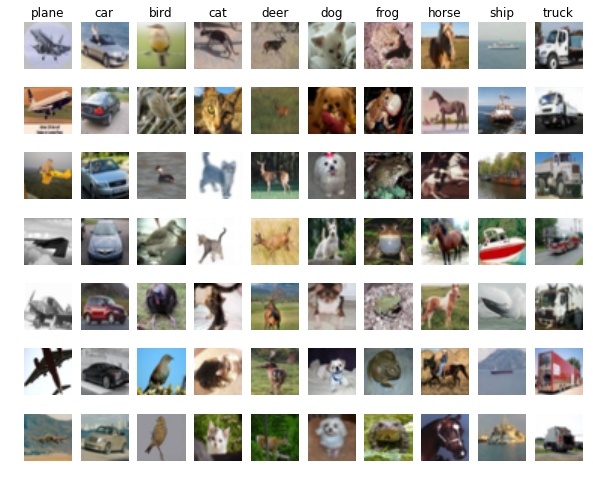

In [15]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
plt.figure(figsize=(10, 8))
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Three layer Network

The [first CNN](https://github.com/martykube/cs231n/blob/master/assignment2/cs231n/classifiers/cnn.py) I trained has a simple architecture:

```
conv - relu - 2x2 max pool - affine - relu - affine - softmax

conv - Convolutional network layer
relu - Rectified linear unit
max pool - Max pooling
affine - Fully connected neural network
softmax - Softmax classifier for loss
```

I also added batch normalization between the affine - relu layers and likewise I added spatial batch normilization between the conv - relu layers.
 
The detailed training is in [this notebook](https://github.com/martykube/cs231n/blob/master/assignment2/ConvolutionalNetworks.ipynb)

I used a coarse to fine strategy for tuning hyper parameters.  Many fine grained tuning runs were performed at 4 epocs.  Here are the results of hyperparamter tuning:

![hyperparameters](hyperparameters.png)

The top result show about 70% validation accuracy.  I did a few runs at 10 epocs and the following is a typical loss curve:

![loss curve](loss.png)

And training versus validation accuracy:

![validateion error](validate.png)

At 4 epocs I saw a lot of overfitting with training accuracy approaching 95%.  For the 10 epoch run the overfitting is less as I increased the regularization.  However, the validation accuracy was not better than 70%.

Deep neural networks perform better.  I stopped here with the simple 3 layer model moved to a deeper neural network.

# Deeper network

The second CNN model allowed for many convolution layers and also had a more convolutions per layer:


> (conv - sbn - relu - conv - sbn - relu - 2x2 max pool)XM - affine - bn - relu - affine - softmax

The 2x2 pooling layer reduces the spatial dimension by half.  Our starting dimension is 32x32 and after 4 layers the image extent is 2x2.  So the range of M that I explored was [1-4].

After developing the code I ran through loss and gradent sanity checks.  I also overfit a small dataset

![loss and accuracy curves for overfitting](m2-overfit.png)

After a few dozen runs I settled on the following hyperparameters

| Paramater | Value |
|-----------|-------|
| Hiddem Dim | 150 |
| Regularization | 4.32e-4 | 
| Learning rate | 2.75e-4 |
| Gradient update | rmsprop |
| filter size | 5x5 |
| Filter count | 25|
| Epochs | 12|
| Convolution layers | 3 |

The loss and validation curve:

![Traning loss](m2-loss.png)
![Training accuracy](m2-training-validation.png)


The models seemed to peak out at around 72% accuracy.  As a final step I trained an ensemble of 5 models with the exact same hypeparaters.  The individual model accurcies were:

| Model | Validation Accuracy|
|-------|--------------------|
| 1 | 0.713|
| 2 | 0.686 |
| 3 | 0.721 |
| 4 | 0.716 |
| 5 | 0.722 |

Here is a plot of ensemble valdation accuracy versus the number of models

![Ensemble valdation accuracy](m2-models.png)

From this graph I selected 5 as the number of models to use.  

The final test set accuracy with 5 models was 0.759.



In [ ]:
# Hyper parameter selection for ensemble.  
# Calculates validation accuracy with different number of models in the ensemble.

X = data['X_test']
y = data['y_test']

acc = []
for num_models in range(5, 6):

    print "num_models", num_models
    y_ens_pred = np.empty((y.shape[0], num_models), dtype=int)

    for i in range(num_models):
        solver = solvers[i]
        scores = solver.model.loss(X)
        pred = np.argmax(scores, axis=1)
        y_ens_pred[:, i] = pred

    y_pred = np.empty_like(y)
    for i in range(y_pred.shape[0]):
        y_pred[i] = np.argmax(np.bincount(y_ens_pred[i]))

    acc.append(np.mean(y_pred == y))

print acc